<a href="https://colab.research.google.com/github/alik604/CMPT-419/blob/master/FNGU_LSTM_proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import required Libraries
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import datetime

plt.style.use('fivethirtyeight')
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,23)
end = datetime.date.today()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
AAPL = web.DataReader("AAPL", "yahoo", start, end)
GOOG = web.DataReader("GOOG", "yahoo", start, end)
FB = web.DataReader("FB", "yahoo", start, end)
BABA = web.DataReader("BABA", "yahoo", start, end)
FNGU = web.DataReader("FNGU", "yahoo", start, end)

stocks = pd.DataFrame({
    "FB": FB["Adj Close"],
    "AAPL": AAPL["Adj Close"],
    "GOOG": GOOG["Adj Close"]/10, # get in similar range, for debuging
    "BABA": BABA["Adj Close"],
    "NVDA": web.DataReader("NVDA", "yahoo", start, end)["Adj Close"],
    "AMD": web.DataReader("AMD", "yahoo", start, end)["Adj Close"],
    "SPY": web.DataReader("SPY", "yahoo", start, end)["Adj Close"],
    "QQQ": web.DataReader("QQQ", "yahoo", start, end)["Adj Close"]

    # "FNGU": FNGU["Adj Close"]
})
stocks.dropna(inplace=True)
stocks

pred = 'SPY'

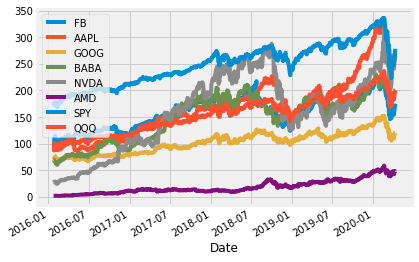

In [0]:
# stocks.FB[-200:]   = [200] * 200
# stocks.AAPL[-200:] = [200] * 200
# stocks.GOOG[-200:] = [200] * 200
# stocks.BABA[-200:] = [200] * 200
# stocks.FNGU[-100:] = [-999] * 100

stocks.plot() # changed 

In [0]:
# FGNU dataset
y = stocks[pred]

# Create dataset with 4 features 
X = stocks.drop([pred],axis=1)
X = X.values

# # set training set len
training_data_len = math.ceil(len(X) * 0.9) # changed by Ali from 0.8

In [0]:
# Scale data 
X_scaler = MinMaxScaler(feature_range=(0,6))
X_scaled = X_scaler.fit_transform(X)

# need to do same for FGNU because we only predict its value 
y_scaler = MinMaxScaler(feature_range=(0,6))
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))


#Create the scaled training data set
X_scaled_train = X_scaled[0:training_data_len, :]
y_scaled_train = y_scaled[0:training_data_len, :]

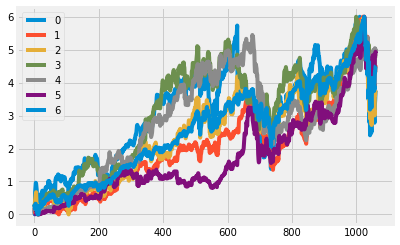

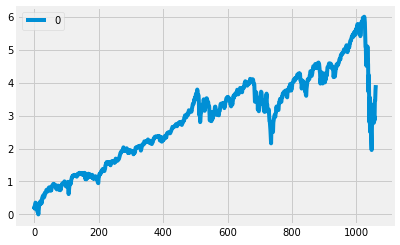

In [0]:
pd.DataFrame(X_scaled).plot()
pd.DataFrame(y_scaled).plot() 


In [0]:
# Split data into x_train and y_train
x_train = []
y_train = []

maxlen = 20

for i in range(maxlen, len(X_scaled_train)): #  len(X_scaled_train)+1) changed added +1; X_scaled_train and x_train[-1], have the same last elem; they are synced 
  x_train.append(X_scaled_train[i-maxlen: i, :])
  y_train.append(y_scaled_train[i])


In [0]:
# Convert both x,y training sets to np array
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data // LSTM network expects 3 dimensional input in the form of 
# (number of samples, number of timesteps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],  x_train.shape[2]))
print(x_train.shape)
print(y_train.shape)

(935, 20, 7)
(935, 1)


In [0]:

# Declare the LSTM model architecture 
## activation funcs are evil.... validation_split and maxlen matter more 
## Add layers , input shape expected is (number of timesteps, number of features)

def makeModel():
  model = Sequential()

  # model.add(LSTM(100, return_sequences=True, stateful=True, batch_size=1, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(LSTM(100,dropout=0.1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))

  model.add(LSTM(135,dropout=0.1, return_sequences=True))   # recurrent_dropout=0.1 will prevent cuDNN, using TF2
  model.add(Dense(160))# sigmoid

  model.add(LSTM(160,dropout=0.1, return_sequences=False))   # recurrent_dropout=0.1 will prevent cuDNN, using TF2
  model.add(Dense(60)) # sigmoid or elu
  model.add(Dense(1))

  # Compile Model 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error') # metrics=['mean_squared_error', 'mae']


  # model = Sequential() # https://colab.research.google.com/gist/gjlr2000/6954900a0f6500bbe41867bb5b2ed140/lstm-ts-us-rates-prediction.ipynb#scrollTo=2QPL2cGGg5kr
  # model.add(LSTM(10, stateful=True,batch_size=batch_size, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
  # model.add(LSTM(10, stateful=True, return_sequences=False))
  # model.add(Dense(units = 1))
  # model.compile(optimizer='adam', loss = 'mae')
  return model



In [0]:
batch_size = 16
callbacks=[]
model = makeModel()

# callbacks.append(EarlyStopping(monitor='loss', patience=12, verbose=1, mode='min', restore_best_weights=False)) # end if loss converges 
stop = EarlyStopping(monitor='val_loss', patience=16, verbose=1, mode='min', restore_best_weights=True) # end if val_loss converges 
callbacks.append(stop)  
callbacks.append(ModelCheckpoint('./my_model.hdf5', save_best_only=True, monitor='val_loss', mode='min'))
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1, mode='min'))

# Train the model 

# Split the data
x_train_v, x_valid_v, y_train_v, y_valid_v = train_test_split(x_train, y_train, test_size=0.05, shuffle= True)
history = model.fit(x_train_v, y_train_v, batch_size=batch_size, epochs=120,  callbacks=callbacks, validation_data=(x_valid_v,y_valid_v),shuffle=True) # valadation_splite is not random. shuffle=False TODO  stateful=True

# MUST shuffle=False if Stateful
# else, either is fine https://stackoverflow.com/a/44789322

Epoch 1/120
56/56 [==============================] - 1s 26ms/step - loss: 0.7046 - val_loss: 0.1445 - lr: 0.0010
Epoch 2/120
56/56 [==============================] - 1s 10ms/step - loss: 0.2397 - val_loss: 0.3837 - lr: 0.0010
Epoch 3/120
56/56 [==============================] - 1s 10ms/step - loss: 0.1439 - val_loss: 0.3498 - lr: 0.0010
Epoch 4/120
56/56 [==============================] - 1s 10ms/step - loss: 0.1270 - val_loss: 0.1741 - lr: 0.0010
Epoch 5/120
56/56 [==============================] - 1s 11ms/step - loss: 0.0990 - val_loss: 0.0673 - lr: 0.0010
Epoch 6/120
56/56 [==============================] - 1s 10ms/step - loss: 0.0867 - val_loss: 0.0764 - lr: 0.0010
Epoch 7/120
56/56 [==============================] - 1s 10ms/step - loss: 0.0826 - val_loss: 0.2409 - lr: 0.0010
Epoch 8/120
56/56 [==============================] - 1s 10ms/step - loss: 0.0788 - val_loss: 0.0532 - lr: 0.0010
Epoch 9/120
56/56 [==============================] - 1s 10ms/step - loss: 0.0733 - val_loss: 0.1

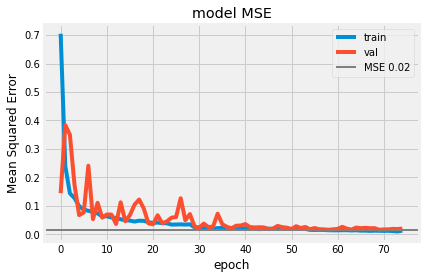

loss 		 0.010030415840446949
val loss 	 0.01590767875313759


In [0]:
# history.history.keys()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(stop.best,linewidth=2, color='gray')
plt.title('model MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'MSE '+str(round(stop.best,2))], loc='upper right')
plt.show()
print('loss \t\t', min(history.history['loss']))
print('val loss \t', min(history.history['val_loss']))

In [0]:
print(model.evaluate(x_train,y_train,batch_size=batch_size,verbose=0)) 
# model.set_weights(stop.best_weights)
# model = save.model
print(model.evaluate(x_train,y_train,batch_size=batch_size,verbose=0)) 

0.008832992985844612
0.008832992985844612


In [0]:
# Create the testing data set
X_scaled_test = X_scaled[training_data_len - maxlen: , :] # X_scaled_test and x_test have the same first & last elems; they are in sync 

# Create the data sets x_test and y_test
x_test = []
y_test = y_scaled[training_data_len:,] 

for i in range(maxlen, len(X_scaled_test)): # len(X_scaled_test)+1 # TODO 
  x_test.append(X_scaled_test[i-maxlen:i, :]) # 0...60, 1..61,,,, 

In [0]:
print(len(x_test))
print(len(y_test))
print('-----------')
print(X.shape)
print(x_train.shape[0])
print(len(x_test))
print('missing data...adds to: ',x_train.shape[0] + len(x_test))

106
106
-----------
(1061, 7)
935
106
missing data...adds to:  1041


In [0]:
# Convert the data into a np array
x_test = np.array(x_test)

# # Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [0]:
# model.reset_states() 
LSTM_fit_training = y_scaler.inverse_transform(model.predict(x_train, batch_size=batch_size).reshape(1,-1))[0] # changed 
# model.reset_states() 
# Get the models predicted price values 
predictions = model.predict(x_test, batch_size=batch_size)

# Inverse transform 
predictions = y_scaler.inverse_transform(predictions.reshape(1,-1)) # changed 
predictions = predictions[0]

In [0]:
# Evaluate model with root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions-y[training_data_len:])**2))
rmse

27.868860020352887

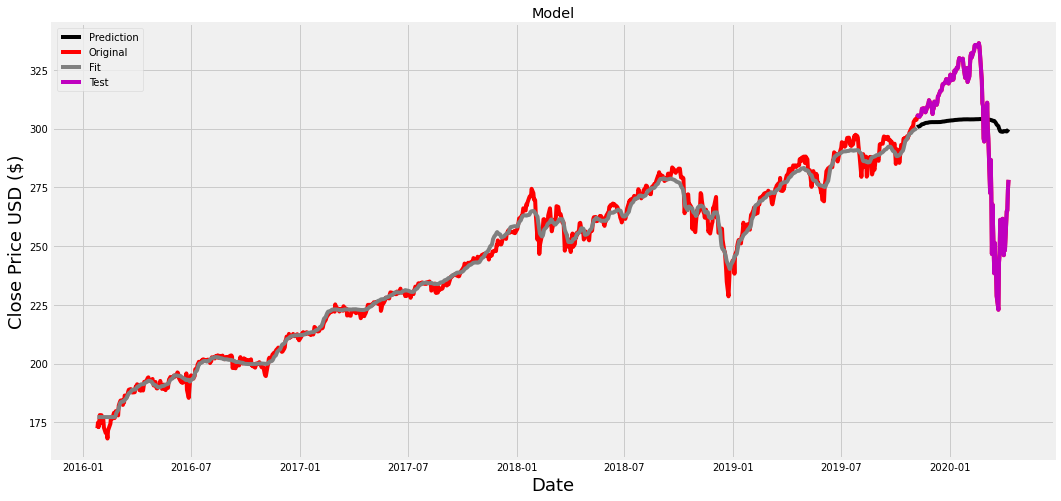

In [0]:
# Set up ploting dataset
train = y[:training_data_len]
train = train.to_frame()
train['LSTM_fit_training'] =  [LSTM_fit_training[0]] *(len(train)-len(LSTM_fit_training)) + list(LSTM_fit_training)

valid = y[training_data_len:]
valid = valid.to_frame()
valid['pred'] = predictions


# # Visualize data
labels = ['Test', 'Original','Prediction', 'Fit']
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid['pred'], label = labels[2],color = 'k')
plt.plot(stocks[pred], label = labels[1],color = 'r')
plt.plot(train['LSTM_fit_training'], label = labels[3],color = 'gray')
plt.plot(valid[pred], label = labels[0], color = 'm')
plt.legend()
plt.show()

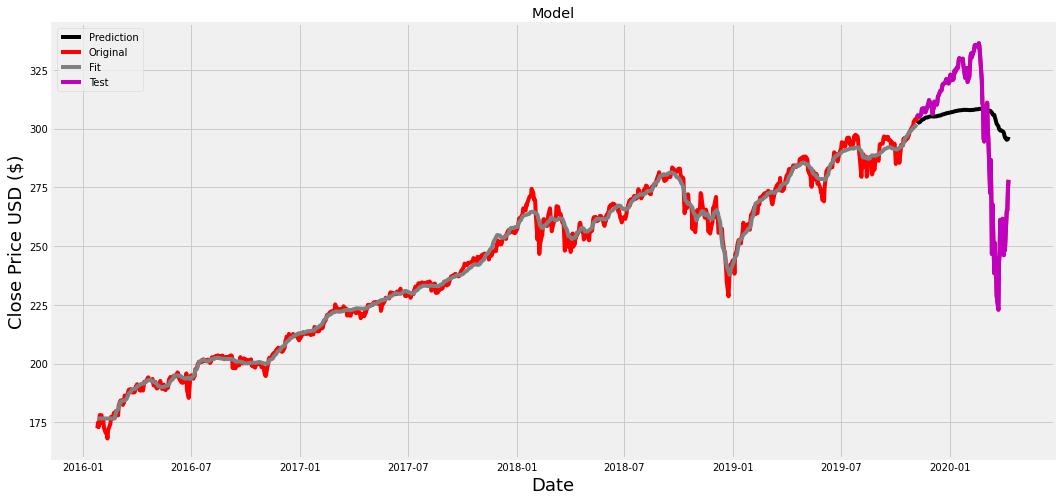

In [0]:
# # Visualize data
labels = ['Test', 'Original','Prediction', 'Fit']
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid['pred'], label = labels[2],color = 'k')
plt.plot(stocks[pred], label = labels[1],color = 'r')
plt.plot(train['LSTM_fit_training'], label = labels[3],color = 'gray')
plt.plot(valid[pred], label = labels[0], color = 'm')
plt.legend()
plt.show()

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [0]:
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=None
)

True

 TODO 

 * fix small overlap is train and test sets
 * deal with missing data points of size = maxlex 
 * have weights reusing 
 * better initialization 
 * gradient clipping?
 * what the fuck did changing scaler from (0,1) -> (0,6) yeild better fitting 
 * am i using best weigths? 

In [0]:
# #get_test_data    
# data_windows = []
# for i in range(len_test - sequence_length):
#     data_windows.append(data_test[i:i+sequence_length])
# data_windows = np.array(data_windows).astype(float)
#  # get original y_test
# y_test_ori = data_windows[:, -1, [0]]
# print('y_test_ori.shape',y_test_ori.shape)

In [0]:
## https://github.com/Xinyi6/DP-LSTM-Differential-Privacy-inspired-LSTM-for-Stock-Prediction-Using-Financial-News/blob/master/code/7_DP_LSTM.py
# model = Sequential()
# model.add(LSTM(50, input_shape=(input_timesteps, input_dim), return_sequences = True))
# model.add(Dropout(0))
# model.add(LSTM(50,return_sequences = True))
# model.add(LSTM(50,return_sequences =False))
# model.add(Dropout(0))
# model.add(Dense(1, activation='linear'))
# # Compile model
# model.compile(loss='mean_squared_error',
#                 optimizer='adam')
# # Fit the model
# model.fit(x_train,y_train,epochs=epochs,batch_size=100)

In [0]:

# model.summary()

In [0]:
yy = range(25)



yy

range(0, 25)

In [0]:
train_test_split(yy, test_size=10,shuffle=False, random_state=42)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]